In [1]:
import sys
sys.path.append("../../../")

## 数据

In [2]:
from pylib.utils.functions_for_regression import lin_data, plot_scatter
import matplotlib.pyplot as plt

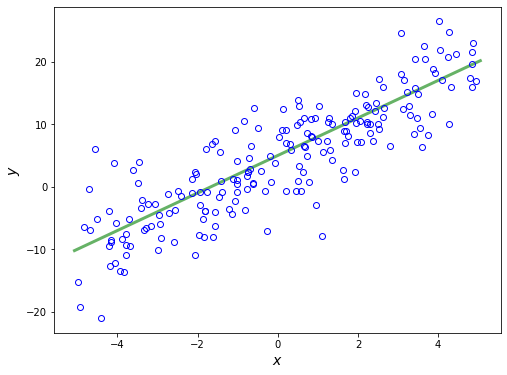

In [3]:
x, y, _, f_truth = lin_data(200)
plt.figure(figsize=(8, 6))
plot_scatter(x, y, f=f_truth)
plt.show()

## The Lasso

In [4]:
from pylib.utils.functions_for_regression import plot_fitted_line
import matplotlib.pyplot as plt
import numpy as np
import ipyvolume.pylab as plt3d

### 粗糙度惩罚项

In [5]:
J = lambda W: np.sum(np.abs(W))

In [6]:
w0n = np.linspace(-1, 1, 100)
w1n = np.linspace(-1, 1, 100)
ww0n, ww1n = np.meshgrid(w0n, w1n)
Wn = np.c_[ww0n.ravel(), ww1n.ravel()]
Jn = np.array([J(w) for w in Wn]).reshape(ww0n.shape)

plt3d.figure(width=1000, height=500)
plt3d.plot_surface(ww0n, Jn, ww1n, color="blue")
plt3d.xlabel("w0")
plt3d.zlabel("w1")
plt3d.ylabel("J")
plt3d.show()

### 成本函数

In [7]:
def regularized_mean_squared_loss(X, W, y, alpha=1.0):
    y_pred = X @ W
    return np.sum((y - y_pred.ravel())**2) + alpha * np.sum(np.abs(W))

### 坐标下降

In [31]:
def coordinate_descent(X, y, alpha, learning_rate=0.1, epochs=200, random_state=None):
    np.random.seed(random_state)
    p = X.shape[1]
    W = np.random.randn(p, 1)
    weight_history = [W.copy()] 
    loss = regularized_mean_squared_loss(X, W, y, alpha)
    loss_history = [loss] 
    for k in range(1, epochs + 1):
        c = np.random.permutation(p) # 对坐标随机洗牌

        # 循环遍历每个坐标
        for n in range(p):
            direction = np.zeros((p, 1))
            direction[c[n]] = 1
            
            if n > 1: 
                    weight_diff = np.abs(np.sum(np.abs(weight_history[-1]) - np.abs(weight_history[-2])))
                    if weight_diff < tol:
                        return weight_history, loss_history
                    
            # 估计并比较两个坐标方向上的损失值
            evals = []
            direction1 = W + learning_rate * direction
            direction2 = W - learning_rate * direction
            evals.append(regularized_mean_squared_loss(X, direction1, y, alpha))  # the first coordinate
            evals.append(regularized_mean_squared_loss(X, direction2, y, alpha))  # the second coordinate
            evals = np.array(evals)
            
            ind = np.argmin(evals)  #  找到损失值最小的坐标方向索引
            if evals[ind] < loss_history[-1]:
                W = W + ((-1) ** (ind)) * learning_rate * direction  # 权重更新公式
                loss = evals[ind]
        weight_history.append(W)
        loss_history.append(regularized_mean_squared_loss(X, W, y, alpha))
        
    return weight_history, loss_history

In [32]:
learning_rate = 0.1
alpha = 100
X = np.c_[np.ones(len(x)), x]
weight_history, loss_history = coordinate_descent(X, y, alpha, learning_rate, random_state=42)

In [33]:
W = weight_history[-1]
W

array([[4.09671415],
       [2.9617357 ]])

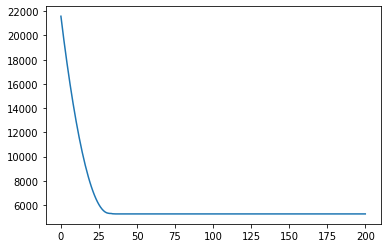

In [34]:
plt.plot(range(len(loss_history)), loss_history)
plt.show()

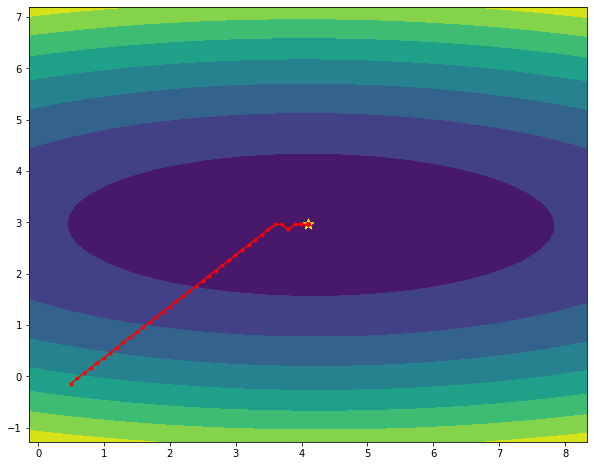

In [36]:
max_interval = np.abs(np.max(weight_history) - np.min(weight_history))
w0n_min = W[0] - max_interval
w0n_max = W[0] + max_interval
w1n_min = W[1] - max_interval
w1n_max = W[1] + max_interval
w0n = np.linspace(w0n_min, w0n_max, 100)
w1n = np.linspace(w1n_min, w1n_max, 100)
ww0n, ww1n = np.meshgrid(w0n, w1n)
WW = np.c_[ww0n.ravel(), ww1n.ravel()]
lossn = np.array([regularized_mean_squared_loss(X, ww, y, alpha) for ww in WW]).reshape(ww0n.shape)
w0_path = np.array(weight_history)[:, 0]
w1_path = np.array(weight_history)[:, 1]

plt.figure(figsize=(10, 8))
plt.contourf(ww0n, ww1n, lossn)
plt.scatter(W[0], W[1], c='yellow', marker='*', s=120)
plt.plot(w0_path, w1_path, 'r.-')
plt.show()

In [37]:
plt3d.figure(width=1000, height=500)
plt3d.plot_surface(ww0n, lossn, ww1n, color="green")
plt3d.scatter(w0_path.ravel(), np.array(loss_history).ravel(), w1_path.ravel(), 
              marker='sphere', size=1.5)
plt3d.plot(w0_path.ravel(), np.array(loss_history).ravel(), w1_path.ravel()) 
plt3d.scatter(W[0], np.array([loss_history[-1]]), W[1], color='yellow', size=3)
plt3d.xlabel("w0")
plt3d.zlabel("w1")
plt3d.ylabel("mse")
plt3d.show()

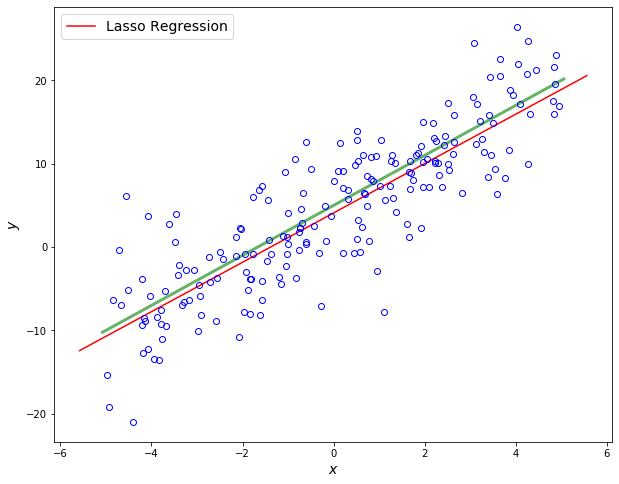

In [39]:
plt.figure(figsize=(10, 8))
plot_scatter(x, y, f=f_truth)
xn = np.linspace(plt.xlim()[0], plt.xlim()[1], 100)
yn = W[0] + W[1] * xn
plt.plot(xn, yn, "r", label="Lasso Regression")
plt.legend(fontsize=14)
plt.show()